In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.graphics.tsaplots import plot_acf

### 1.Import Dataset

In [3]:
data_train = pd.read_csv("Google_Stock_Price_Train.csv")
data_test = pd.read_csv("Google_Stock_Price_Test.csv")

In [4]:
data_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [7]:
data_train['Close'] = pd.to_numeric(data_train['Close'].str.replace(',', ''))
data_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [8]:
data_train['Date'] = pd.to_datetime(data_train['Date'])
data_test['Date'] = pd.to_datetime(data_test['Date'])

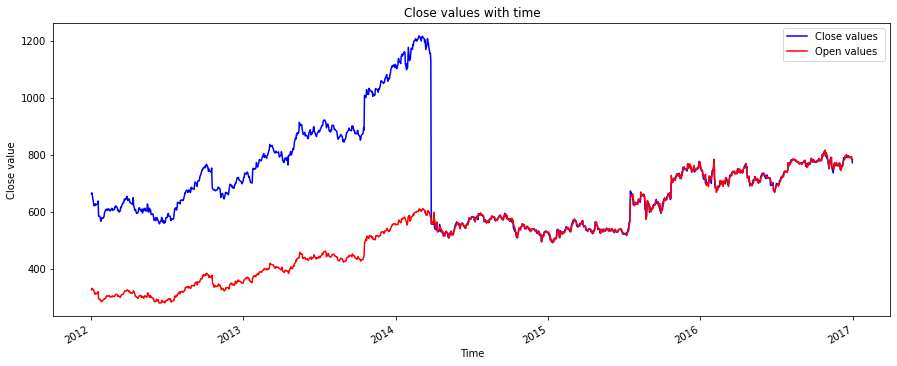

In [10]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.plot(data_train['Date'], data_train['Close'], color = 'blue', label = 'Close values ')
axes.plot(data_train['Date'], data_train['Open'], color = 'red', label = 'Open values ')
plt.title('Close values with time')
plt.xlabel('Time')
plt.ylabel('Close value')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

### 2.Data preparation

In [11]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(data_train['Close'].values.reshape(-1, 1))
X_test_scaled = scaler.transform(data_test['Close'].values.reshape(-1, 1))

In [12]:
# Split Train Data into Train and Validation Sets
size = int(len(X_train_scaled) * 0.80)  
train_X = X_train_scaled[:size]
val_X = X_train_scaled[size:]
test_X = X_test_scaled

In [15]:
# Create sequences for RNN input
def create_sequences(data, seq=30):
    feature = []
    target = []
    for i in range(len(data)-seq):
        feature.append(data[i:i+seq])
        target.append(data[i+seq])
    return np.array(feature), np.array(target)


seq_len= 10  
X_train, y_train = create_sequences(train_X, seq_len)
X_val, y_val = create_sequences(val_X, seq_len)
X_test, y_test = create_sequences(test_X, seq_len)


print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (996, 10, 1) y_train: (996, 1)
X_val: (242, 10, 1) y_val: (242, 1)
X_test: (10, 10, 1) y_test: (10, 1)


### 3.Model Build

#### Simple RNN

In [71]:
def Create_SimpleRNN():
    model = Sequential([
        SimpleRNN(32, activation='tanh', return_sequences=False, input_shape=(seq_len, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

#### Multi-Simple RNN with Dropout

In [85]:
def Create_MultiRNN():
    model = Sequential([
        SimpleRNN(32, activation='tanh', return_sequences=True, input_shape=(seq_len, 1)), 
        Dropout(0.1),
        SimpleRNN(16, activation='tanh', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

#### LSTM

In [86]:
def Create_Lstm():
    model = Sequential([ 
        LSTM(32, activation='tanh', return_sequences=False, input_shape=(seq_len, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

#### GRU

In [74]:
def Create_GRU():
    model = Sequential([
        GRU(32, activation='tanh', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

### 4.Train the model

In [88]:
# Train and Evaluate Models
def train_model(model, X_train, y_train, X_val, y_val, name):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=30, batch_size=32, callbacks=[early_stopping], verbose=1)

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model

Epoch 1/30
32/32 [==============================] - 1s 11ms/step - loss: 0.0188 - val_loss: 9.5435e-04
Epoch 2/30
32/32 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 5.8737e-04
Epoch 3/30
32/32 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 5.8731e-04
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 8.1838e-04
Epoch 5/30
32/32 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/30
32/32 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 5.2183e-04
Epoch 7/30
32/32 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 6.0205e-04
Epoch 8/30
32/32 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 7.3203e-04
Epoch 9/30
32/32 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 3.0007e-04
Epoch 10/30
32/32 [==============================] - 0s 3ms/step - loss: 0.0014 - val

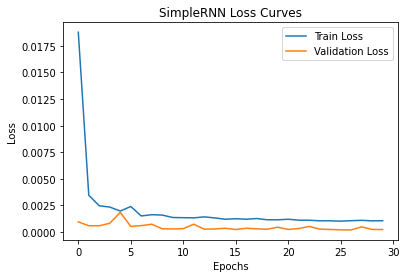

In [89]:
model_list=[]
model=Create_SimpleRNN()
model = train_model(model, X_train, y_train, X_val, y_val, "SimpleRNN")
model_list.append(model)

Epoch 1/30
32/32 [==============================] - 2s 27ms/step - loss: 0.1035 - val_loss: 0.0031
Epoch 2/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0012
Epoch 3/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.0013
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 6.8148e-04
Epoch 5/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 6.0754e-04
Epoch 6/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 5.2580e-04
Epoch 7/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 7.0786e-04
Epoch 8/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 4.7468e-04
Epoch 9/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 8.2621e-04
Epoch 10/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0

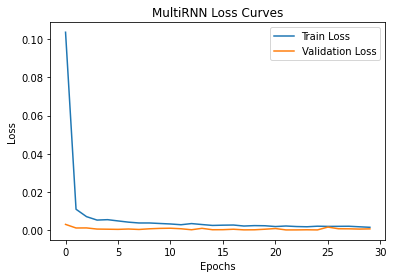

In [90]:
model=Create_MultiRNN()
model = train_model(model, X_train, y_train, X_val, y_val, "MultiRNN")
model_list.append(model)

Epoch 1/30
32/32 [==============================] - 2s 18ms/step - loss: 0.0546 - val_loss: 0.0051
Epoch 2/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 5.9398e-04
Epoch 3/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0010
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 6.2607e-04
Epoch 5/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 7.1656e-04
Epoch 6/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 7/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 6.8156e-04
Epoch 8/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 7.0470e-04
Epoch 9/30
32/32 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 5.6912e-04
Epoch 10/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 5

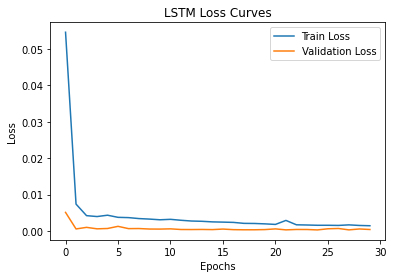

In [91]:
model=Create_Lstm()
model = train_model(model, X_train, y_train, X_val, y_val, "LSTM")
model_list.append(model)

Epoch 1/30
32/32 [==============================] - 3s 19ms/step - loss: 0.0113 - val_loss: 4.2032e-04
Epoch 2/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 2.7996e-04
Epoch 3/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 4.4981e-04
Epoch 4/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 2.6026e-04
Epoch 5/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 3.6008e-04
Epoch 6/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 2.4494e-04
Epoch 7/30
32/32 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 2.4798e-04
Epoch 8/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 2.4475e-04
Epoch 9/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 2.3069e-04
Epoch 10/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0012 -

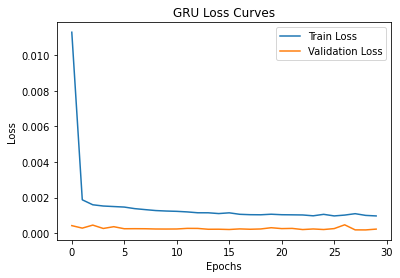

In [92]:
model=Create_GRU()
model = train_model(model, X_train, y_train, X_val, y_val, "GRU")
model_list.append(model)

In [93]:
model_list

### 5.Evaluate the model

In [94]:
# Evaluate Model on Test Set
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(" MSE value: ", MSE)
    print(" MAE value: ", MAE)
    print(" R2  score: ", r2)
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Real Prices')
    plt.plot(y_pred, label='Predict Prices')
    plt.title('Real vs Predict Prices')
    plt.xlabel('Time')
    plt.ylabel('cloase Price')
    plt.legend()
    plt.show()
    return MSE, MAE,r2

1/1 [==============================] - 0s 112ms/step
 MSE value:  0.00033585552241291173
 MAE value:  0.015987987648291947
 R2  score:  -0.026403448999530843


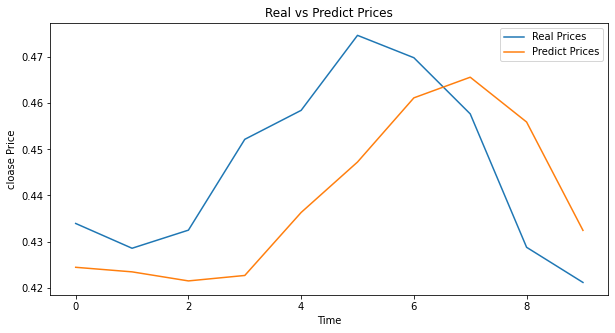

(0.00033585552241291173, 0.015987987648291947, -0.026403448999530843)

In [96]:
evaluate_model(model_list[0], X_test, y_test)

1/1 [==============================] - 0s 196ms/step
 MSE value:  0.0012943264306233989
 MAE value:  0.031312212805925575
 R2  score:  -2.9555732267811456


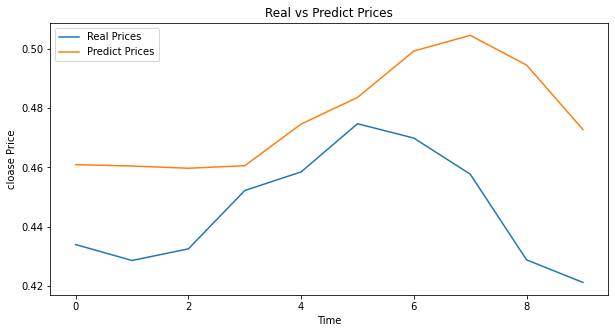

(0.0012943264306233989, 0.031312212805925575, -2.9555732267811456)

In [97]:
evaluate_model(model_list[1], X_test, y_test)

1/1 [==============================] - 0s 343ms/step
 MSE value:  0.0006919534479757156
 MAE value:  0.02048430646127748
 R2  score:  -1.1146694282317622


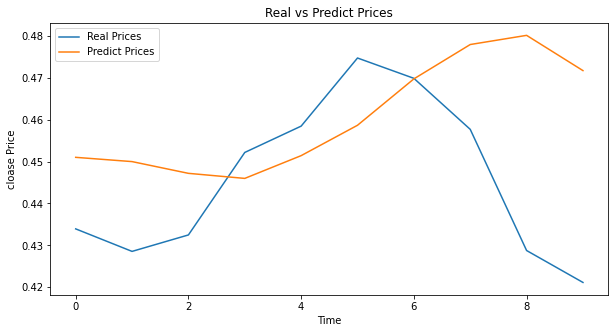

(0.0006919534479757156, 0.02048430646127748, -1.1146694282317622)

In [98]:
evaluate_model(model_list[2], X_test, y_test)

1/1 [==============================] - 0s 301ms/step
 MSE value:  0.00033270818678359426
 MAE value:  0.01479866288533247
 R2  score:  -0.016784919812093513


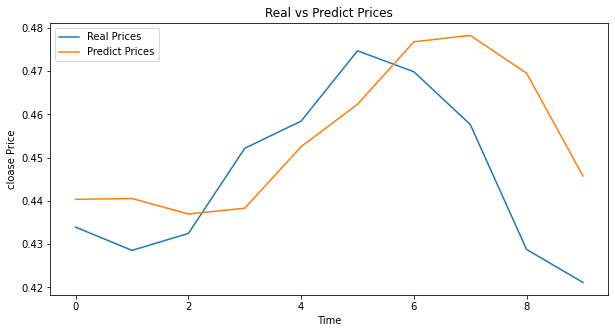

(0.00033270818678359426, 0.01479866288533247, -0.016784919812093513)

In [99]:
evaluate_model(model_list[3], X_test, y_test)

1/1 [==============================] - 0s 18ms/step


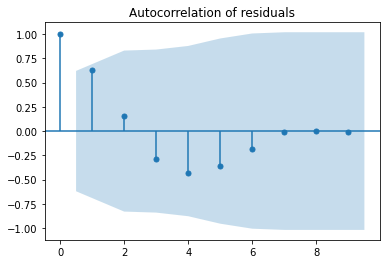

1/1 [==============================] - 0s 20ms/step


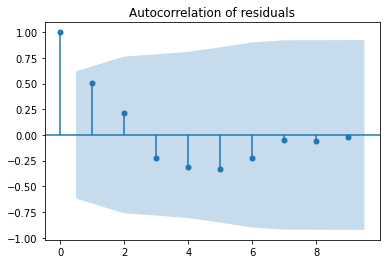

1/1 [==============================] - 0s 27ms/step


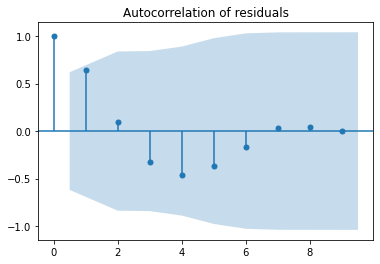

1/1 [==============================] - 0s 20ms/step


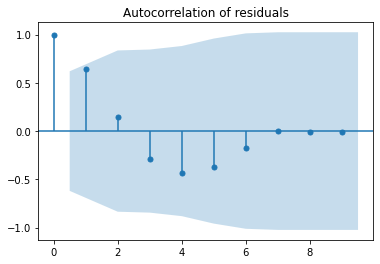

In [84]:
def plot_residuals_autocorrelation(y_true, y_pred):
    # Calculate residuals
    residuals = y_true.flatten() - y_pred.flatten()
    plot_acf(residuals, lags=9)
    plt.title("Autocorrelation of residuals")
    plt.show()

for model in model_list:
    y_pred = model.predict(X_test)
    plot_residuals_autocorrelation(y_test, y_pred)